In [ ]:
# Importing the relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import gurobipy as gp
from gurobipy import GRB

In [ ]:
# Defining all the sets
suppliers = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24']
carriers = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20']
zones = ['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'Z10', 'Z11','Z12','Z13','Z14','Z15','Z16','Z17','Z18','Z19','Z20','Z21','Z22','Z23','Z24','Z25',
                  'Z26','Z27','Z28','Z29','Z30', 'Z31', 'Z32', 'Z33', 'Z34', 'Z35', 'Z36', 'Z37', 'Z38', 'Z39', 'Z40', 'Z41', 'Z42', 'Z43','Z44','Z45', 'Z46', 'Z47', 'Z48']
production_days = [0, 1, 2, 3, 4, 5, 6, 7]

In [ ]:
# Loading all the datasets and creating the necessary dictionaries
# Demand per zone
demand_df = pd.read_excel("~/Desktop/thesis_final_data/annual_demand.xlsx")
demand = {(row["Zone"]): row["Demand"] for index, row in demand_df.iterrows()}

# Supplier capacity
capacity_df = pd.read_excel("~/Desktop/thesis_final_data/supplier_capacity.xlsx")
capacity = {(row["supplier_id"]): row["capacity"] for index, row in capacity_df.iterrows()}

# Product costs dependent on days
adjusted_product_cost_df = pd.read_excel("~/Desktop/thesis_final_data/adjusted_product_cost_days.xlsx")
adjusted_product_cost = {(row["supplier_id"], row["zone_id"], row["prod_days"]): row["product_cost"] for index, row in adjusted_product_cost_df.iterrows()}

# Carrier cost
carrier_cost_df = pd.read_excel('~/Desktop/thesis_final_data/carrier_cost_dictionary_complete.xlsx')
carrier_cost = {(row["carrier_id"], row["supplier_id"], row["zone_id"]): row["carrier_cost"] for index, row in carrier_cost_df.iterrows()}

# Average emissions per parcel, per carrier and linehaul
emissions_df = pd.read_excel("~/Desktop/thesis_final_data/emissions_per_parcel_dictionary_complete.xlsx")
emissions = {(row["supplier_id"], row["zone_id"], row["carrier_id"]): row["average_emissions_actual"] for index, row in emissions_df.iterrows()}

# Supplier-Zone-Production Days availability
supplier_zone_days_availability_df = pd.read_excel("~/Desktop/thesis_final_data/adjusted product cost days.xlsx")
supplier_zone_days = {(row["supplier_id"], row["zone_id"], row["prod_days"]): 1 for index, row in supplier_zone_days_availability_df.iterrows()}

# Carrier-Supplier availability
carrier_supplier_availability_df = pd.read_excel('~/Desktop/thesis_final_data/carrier_supplier_combo.xlsx')
carrier_supplier_availability = {(row["carrier_id"], row["supplier_id"]): 1 for index, row in carrier_supplier_availability_df.iterrows()}

# Carrier-Zone availability
carrier_zone_availability_df = pd.read_excel('~/Desktop/thesis_final_data/carrier_zone_combo.xlsx')
carrier_zone_availability = {(row["carrier_id"], row["zone_id"]): 1 for index, row in carrier_zone_availability_df.iterrows()}

# Total production + carrier days per zone (customer requirement)
total_days_df = pd.read_excel("~/Desktop/thesis_final_data/total_days.xlsx")
total_days = {(row["zone_id"]): row["days"] for index, row in total_days_df.iterrows()}

# Carrier days
carrier_days_df = pd.read_excel("~/Desktop/thesis_final_data/carrier_days_dictionary_complete.xlsx")
carrier_days = {(row["carrier_id"], row["supplier_id"], row["zone_id"]): row["carrier_days"] for index, row in carrier_days_df.iterrows()}

# Social cost of carbon - Emission cost per gram
emission_cost = 0.000195

In [ ]:
# Defining objective weights
alpha_cost_values = [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
beta_emission_values = [round(1 - x, 3) for x in alpha_cost_values]

print(alpha_cost_values)
print(beta_emission_values)

[0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
[1, 0.999, 0.998, 0.997, 0.996, 0.995, 0.994, 0.993, 0.992, 0.991, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]


In [ ]:
# Creating an empty list to store the results
results = []

In [ ]:
# Creating an availability dictionary – all combinations are in this dictionary
# Values will take on either 1 if the combination is available and 0 otherwise
combined_available = {(s, z, c, d): supplier_zone_days.get((s, z, d), 0) *
                                      carrier_supplier_availability.get((c, s), 0) *
                                      carrier_zone_availability.get((c, z), 0)
                         for s in suppliers for z in zones for c in carriers for d in production_days}

In [ ]:
# Defining a large number M
M = 10000000

# Creating the model and initializing it in a loop
for cost_weight, emission_weight in zip(alpha_cost_values, beta_emission_values):
    
    # Create a model
    model = gp.Model()

    # Defining the decision variables #

    # Binary variable of whether a combination gets selected or not
    x = model.addVars(suppliers, zones, carriers, production_days, vtype=GRB.BINARY, name="supplier_zone_carrier_day_combo")

    # Integer variable defining how many orders get fulfilled by a certain supplier, carrier and production days combination for a zone
    y = model.addVars(suppliers, zones, carriers, production_days, vtype=GRB.INTEGER, name="number_of_orders")

    # Availability constraint
    for s in suppliers:
        for z in zones:
            for c in carriers:
                for d in production_days:
                    model.addConstr(x[s, z, c, d] <= combined_available[s, z, c, d])

    # Activation constraint
    for s in suppliers:
        for z in zones:
            for c in carriers:
                for d in production_days:
                    model.addConstr(y[s, z, c, d] <= M * x[s, z, c, d])

    # Demand constraint
    for z in zones:
        model.addConstr(gp.quicksum(x[s, z, c, d] * y[s, z, c, d] for s in suppliers for c in carriers for d in production_days) == demand[z])

    # Capacity constraint
    for s in suppliers:
        model.addConstr(gp.quicksum(x[s, z, c, d] * y[s, z, c, d] for z in zones for c in carriers for d in production_days) <= capacity[s])

    # Total days constraint
    for z in zones:
        for s in suppliers:
            for c in carriers:
                for d in production_days:
                    model.addConstr(x[s, z, c, d] * (d + carrier_days[(c, s, z)]) <= total_days[z])

    # Non-negativity constraint
    for s in suppliers:
        for z in zones:
            for c in carriers:
                for d in production_days:
                    model.addConstr(y[s, z, c, d] >= 0)

    # Defining the objectives #

    # Economic objective
    cost_objective = gp.quicksum(
        (adjusted_product_cost[(s, z, d)] + carrier_cost[(c, s, z)]) * y[s, z, c, d]
        for s in suppliers for z in zones for c in carriers for d in production_days)

    # Environmental objective
    emissions_objective = gp.quicksum(
        emissions[(s, z, c)] * y[s, z, c, d] * emission_cost
        for s in suppliers for z in zones for c in carriers for d in production_days)

    model.setObjectiveN(cost_objective, index=0, weight=cost_weight)
    model.setObjectiveN(emissions_objective, index=1, weight=emission_weight)

    # Optimize the model
    model.optimize()

    # Output the results
    if model.status == GRB.OPTIMAL:
        solution = model.getAttr('x', x)
        cost_objective = model.getObjective(0).getValue()
        environmental_objective = model.getObjective(1).getValue()
        actual_emissions = model.getObjective(1).getValue()/emission_cost/1000
        results.append((cost_weight, 1-cost_weight, cost_objective, environmental_objective, actual_emissions))
        print(f"Weights: Cost={cost_weight}, Emissions={emission_weight}, Actual cost: {cost_objective}, Actual Total emissions: {actual_emissions}")

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 737280 rows, 368640 columns and 921558 nonzeros
Model fingerprint: 0xcfc37738
Model has 72 quadratic constraints
Variable types: 0 continuous, 368640 integer (184320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+07]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e-03, 2e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
  QRHS range       [1e+00, 5e+02]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives (1 combined) ...
---------------------------------------------------------------------------
---------------------------------------------------------------------------

Multi-objectives: optimize objective 1 (weighted) ...
------------------------------

In [ ]:
# Compiling all the models' results into the result_df and printing this dataframe
results_df = pd.DataFrame(results, columns=["Cost Weight", "Emissions Weight", "Actual cost", "Environmental Objective", "Actual Total Emissions"])
print(results_df)

    Cost Weight  Emissions Weight    Actual cost  Environmental Objective  \
0         0.000             1.000  103355.972738                98.229690   
1         0.001             0.999   79396.252501                99.772335   
2         0.002             0.998   79396.252501                99.772335   
3         0.003             0.997   70616.962501               123.461910   
4         0.004             0.996   70588.852501               123.553365   
5         0.005             0.995   70372.441712               124.515105   
6         0.006             0.994   68855.441712               132.371265   
7         0.007             0.993   68454.954843               134.961450   
8         0.008             0.992   68454.954843               134.961450   
9         0.009             0.991   68171.683643               137.376915   
10        0.010             0.990   68171.683643               137.376915   
11        0.020             0.980   66454.889368               160.815720   

In [ ]:
# Exporting the dataframe to an excel file
results_df.to_excel("~/Desktop/results_final.xlsx")

In [ ]:
# Creating an excel file to observe the individual models' results

with pd.ExcelWriter("~/Desktop/model_results/model_results_complete.xlsx") as writer:
    # Loop over the number of objective weight sets
    for iteration, (alpha_cost, beta_emission) in enumerate(zip(alpha_cost_values, beta_emission_values), start=1):    # Model results - individual
        
        # Initialize a model
        model = gp.Model()

        # Define the decision variables #

        # Binary variable of whether a combination gets selected or not
        x = model.addVars(suppliers, zones, carriers, production_days, vtype=GRB.BINARY, name="supplier_zone_carrier_day_combo")

        # Integer variable defining how many orders get fulfilled by a certain supplier, carrier and production days combination for a zone
        y = model.addVars(suppliers, zones, carriers, production_days, vtype=GRB.INTEGER, name="number_of_orders")

        # Availability constraints
        for s in suppliers:
            for z in zones:
                for c in carriers:
                    for d in production_days:
                        model.addConstr(x[s, z, c, d] <= combined_available[s, z, c, d])

        for s in suppliers:
            for z in zones:
                for c in carriers:
                    for d in production_days:
                        model.addConstr(y[s, z, c, d] <= M * x[s, z, c, d])

        # Demand constraint
        for z in zones:
            model.addConstr(gp.quicksum(x[s, z, c, d] * y[s, z, c, d] for s in suppliers for c in carriers for d in production_days) == demand[z])

        # Capacity constraint
        for s in suppliers:
            model.addConstr(gp.quicksum(x[s, z, c, d] * y[s, z, c, d] for z in zones for c in carriers for d in production_days) <= capacity[s])

        # Total days constraint
        for z in zones:
            for s in suppliers:
                for c in carriers:
                    for d in production_days:
                        model.addConstr(x[s, z, c, d] * (d + carrier_days[(c, s, z)]) <= total_days[z])

        # Non-negativity constraint
        for s in suppliers:
            for z in zones:
                for c in carriers:
                    for d in production_days:
                        model.addConstr(y[s, z, c, d] >= 0)

        # Defining the objectives #

        # Economic objective
        cost_objective = gp.quicksum(
            (adjusted_product_cost[(s, z, d)] + carrier_cost[(c, s, z)]) * y[s, z, c, d]
            for s in suppliers for z in zones for c in carriers for d in production_days)

        # Environmental objective
        emissions_objective = gp.quicksum(
            emissions[(s, z, c)] * y[s, z, c, d] * emission_cost
            for s in suppliers for z in zones for c in carriers for d in production_days)

        model.setObjectiveN(cost_objective, index=0, weight=alpha_cost)
        model.setObjectiveN(emissions_objective, index=1, weight=beta_emission)

        # Optimize the model
        model.optimize()

        if model.status == GRB.OPTIMAL:
            solution = model.getAttr('x', y)
            results = []
            for s in suppliers:
                for z in zones:
                    for c in carriers:
                        for d in production_days:
                            if solution[s, z, c, d] > 0:
                                total_product_cost = adjusted_product_cost[(s, z, d)] * solution[s, z, c, d]
                                total_carrier_cost = carrier_cost[(c, s, z)] * solution[s, z, c, d]
                                emissions_value = emissions[(s, z, c)] * solution[s, z, c, d] * emission_cost
                                emissions_total_grams = emissions[(s, z, c)] * solution[s, z, c, d]
                                emissions_total_kg = emissions[(s, z, c)] * solution[s, z, c, d] / 1000
                                results.append({
                                    "Supplier": s,
                                    "Zone": z,
                                    "Carrier": c,
                                    "Production Days": d,
                                    "Number of Orders": solution[s, z, c, d],
                                    "Total Product Cost": total_product_cost,
                                    "Total Carrier Cost": total_carrier_cost,
                                    "Emissions": emissions_value,
                                    "Emissions Amount (gr)": emissions_total_grams,
                                    "Emissions Amount (kg)": emissions_total_kg
                                })
            
            # Create a DataFrame
            df = pd.DataFrame(results)
            
            # Save the DataFrame to an Excel file with a unique name for each iteration
            sheet_name = f"model_{iteration}"
            df.to_excel(writer, sheet_name=sheet_name, index=False)
            print(f"Solution for iteration {iteration} has been exported to sheet '{sheet_name}'")
        else:
            print(f"No optimal solution found for iteration {iteration}")

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 737280 rows, 368640 columns and 921558 nonzeros
Model fingerprint: 0xcfc37738
Model has 72 quadratic constraints
Variable types: 0 continuous, 368640 integer (184320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+07]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e-03, 2e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
  QRHS range       [1e+00, 5e+02]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives (1 combined) ...
---------------------------------------------------------------------------
---------------------------------------------------------------------------

Multi-objectives: optimize objective 1 (weighted) ...
------------------------------

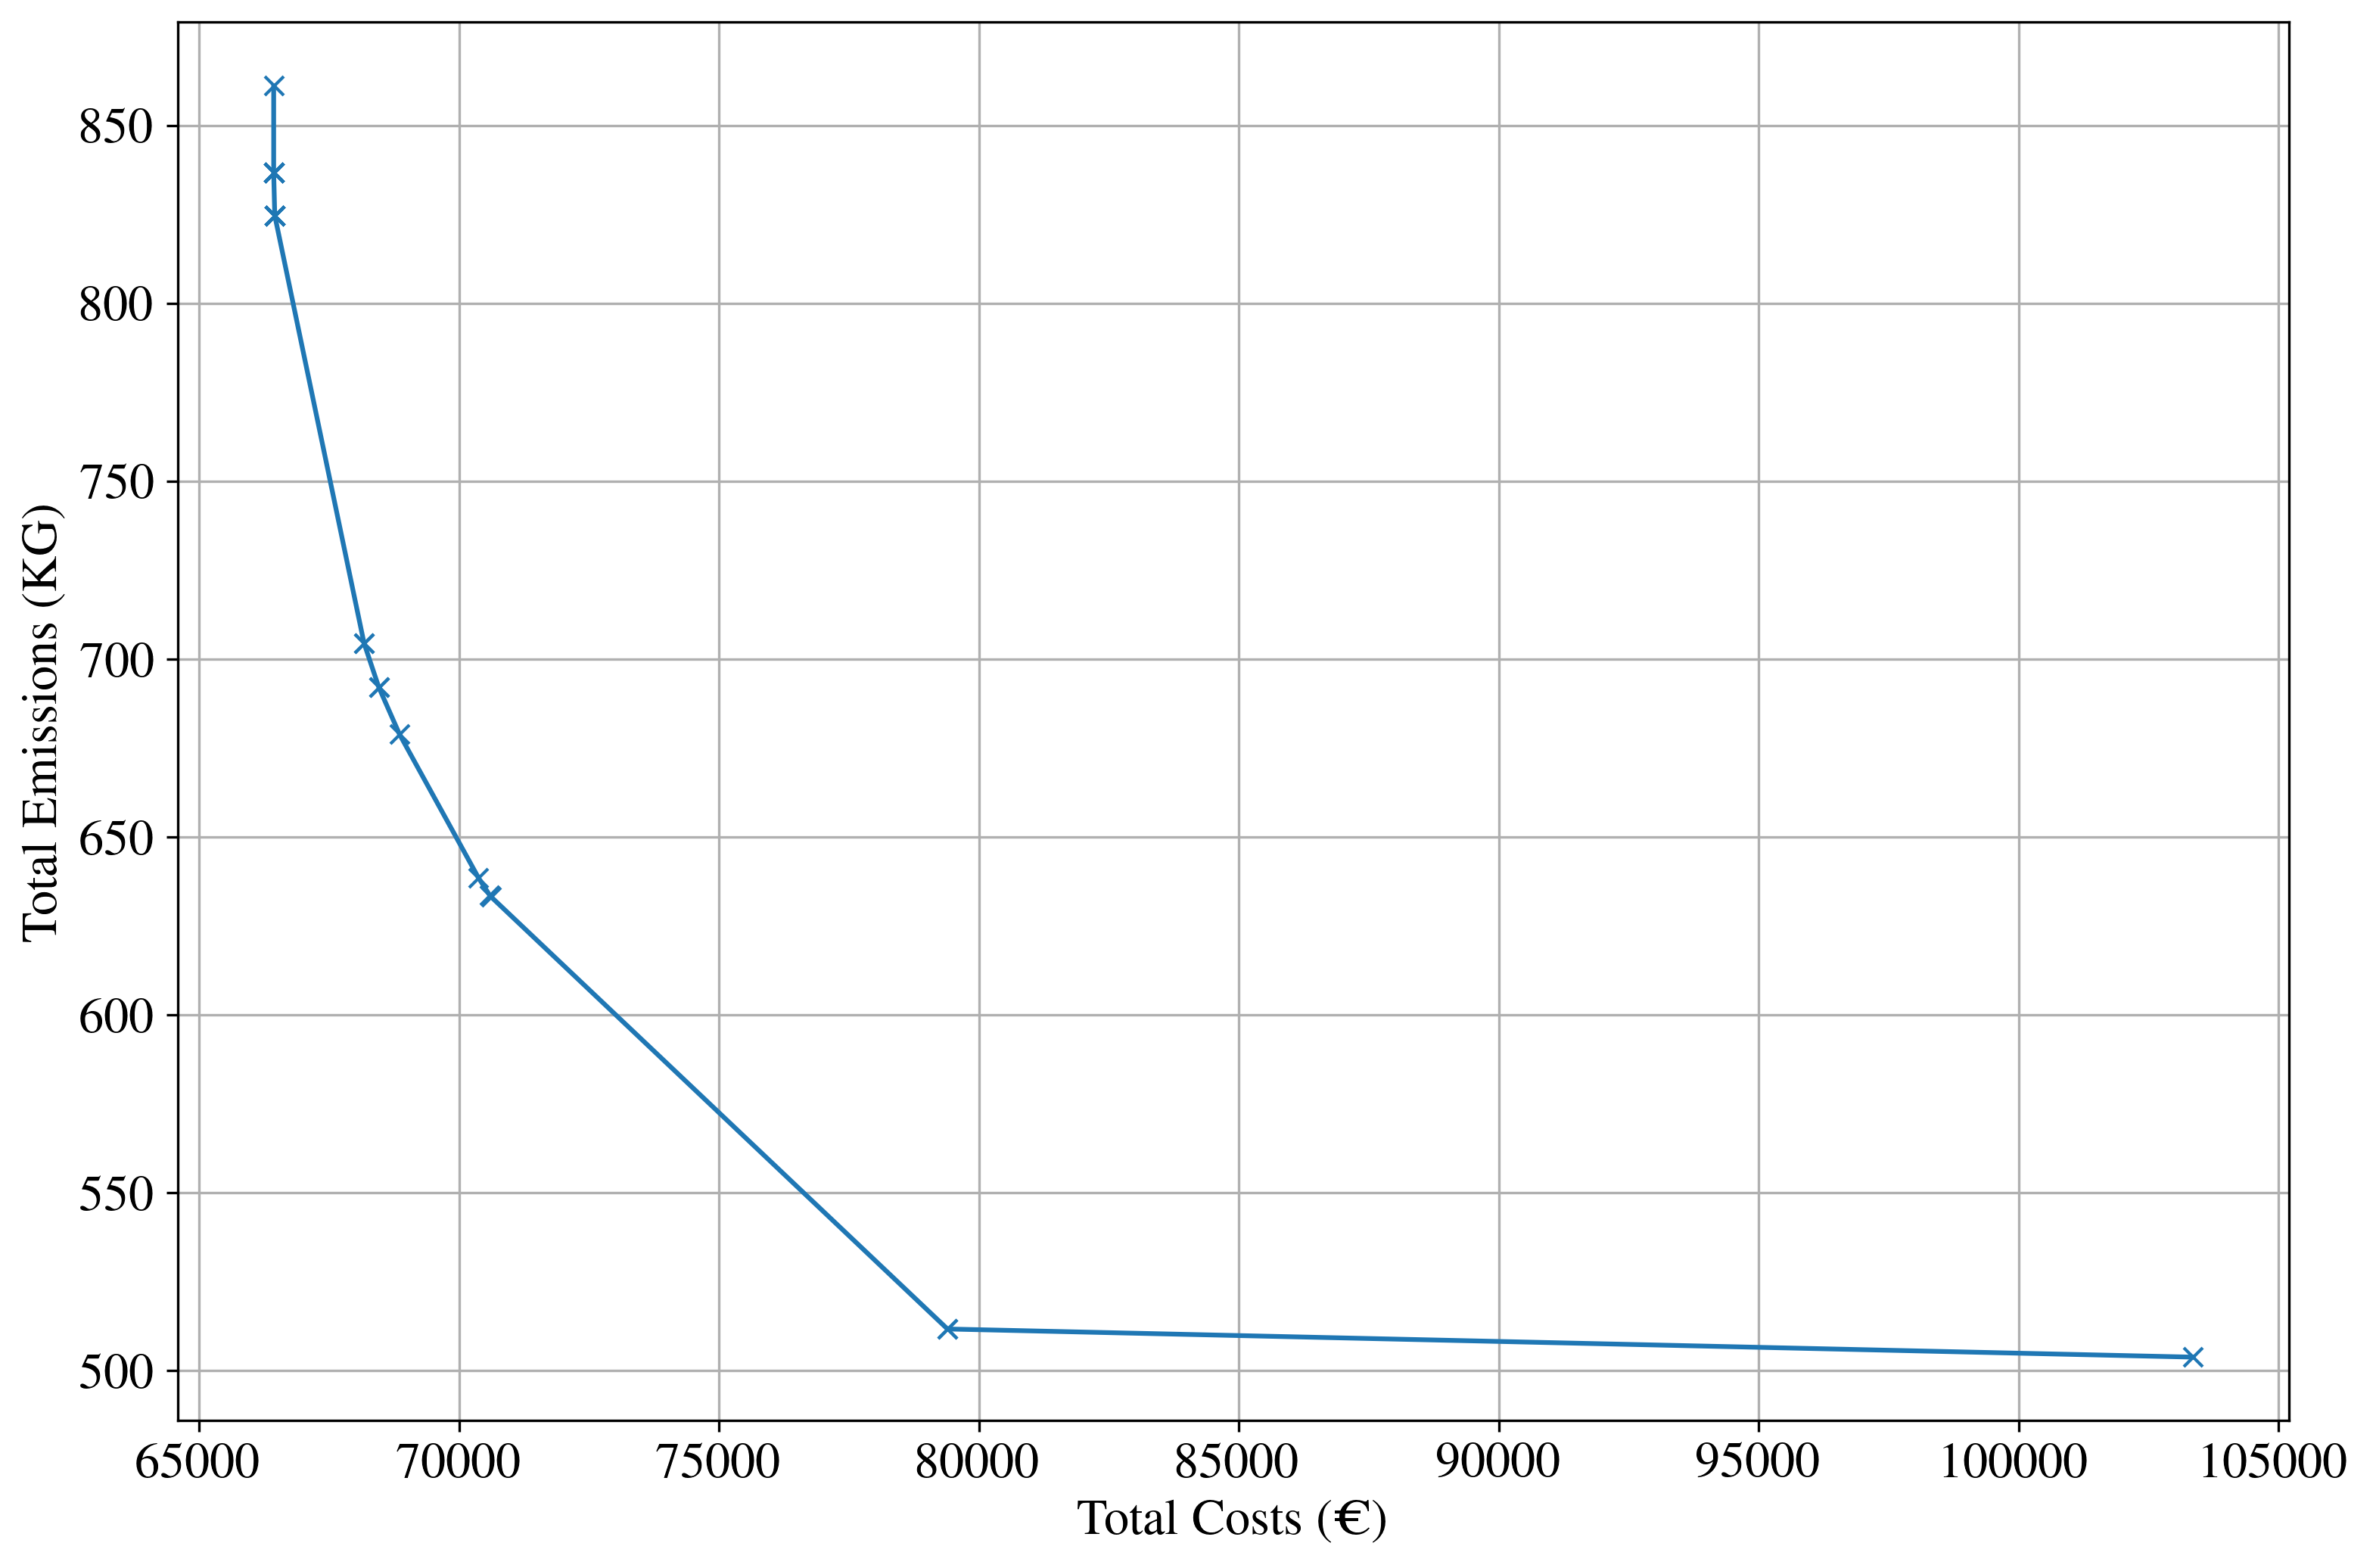

In [ ]:
# Plotting all the points for a pareto frontier
plt.figure(figsize = (12,8), dpi=300)

plt.plot(results_df['Actual cost'], results_df['Actual Total Emissions'], marker='x', label='Total Cost vs Total Emissions')

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 16

plt.ylabel('Total Emissions (KG)')
plt.xlabel('Total Costs (€)')
plt.grid(True)

plt.savefig("pareto_full.png", bbox_inches = 'tight')

plt.show()

In [ ]:
# Plotting the clustered Pareto-frontier

# Initialize list of points
data = [[103355.972738099, 503.742], [79396.2525009828, 511.653], [69210.8719248275, 672.165625], [66444.4493676656, 832.083722222222]]

# Create dataframe
df = pd.DataFrame(data, columns=['Cost_Obj', 'Env_Obj'])

# Print the dataframe to verify
print(df)

        Cost_Obj     Env_Obj
0  103355.972738  503.742000
1   79396.252501  511.653000
2   69210.871925  672.165625
3   66444.449368  832.083722


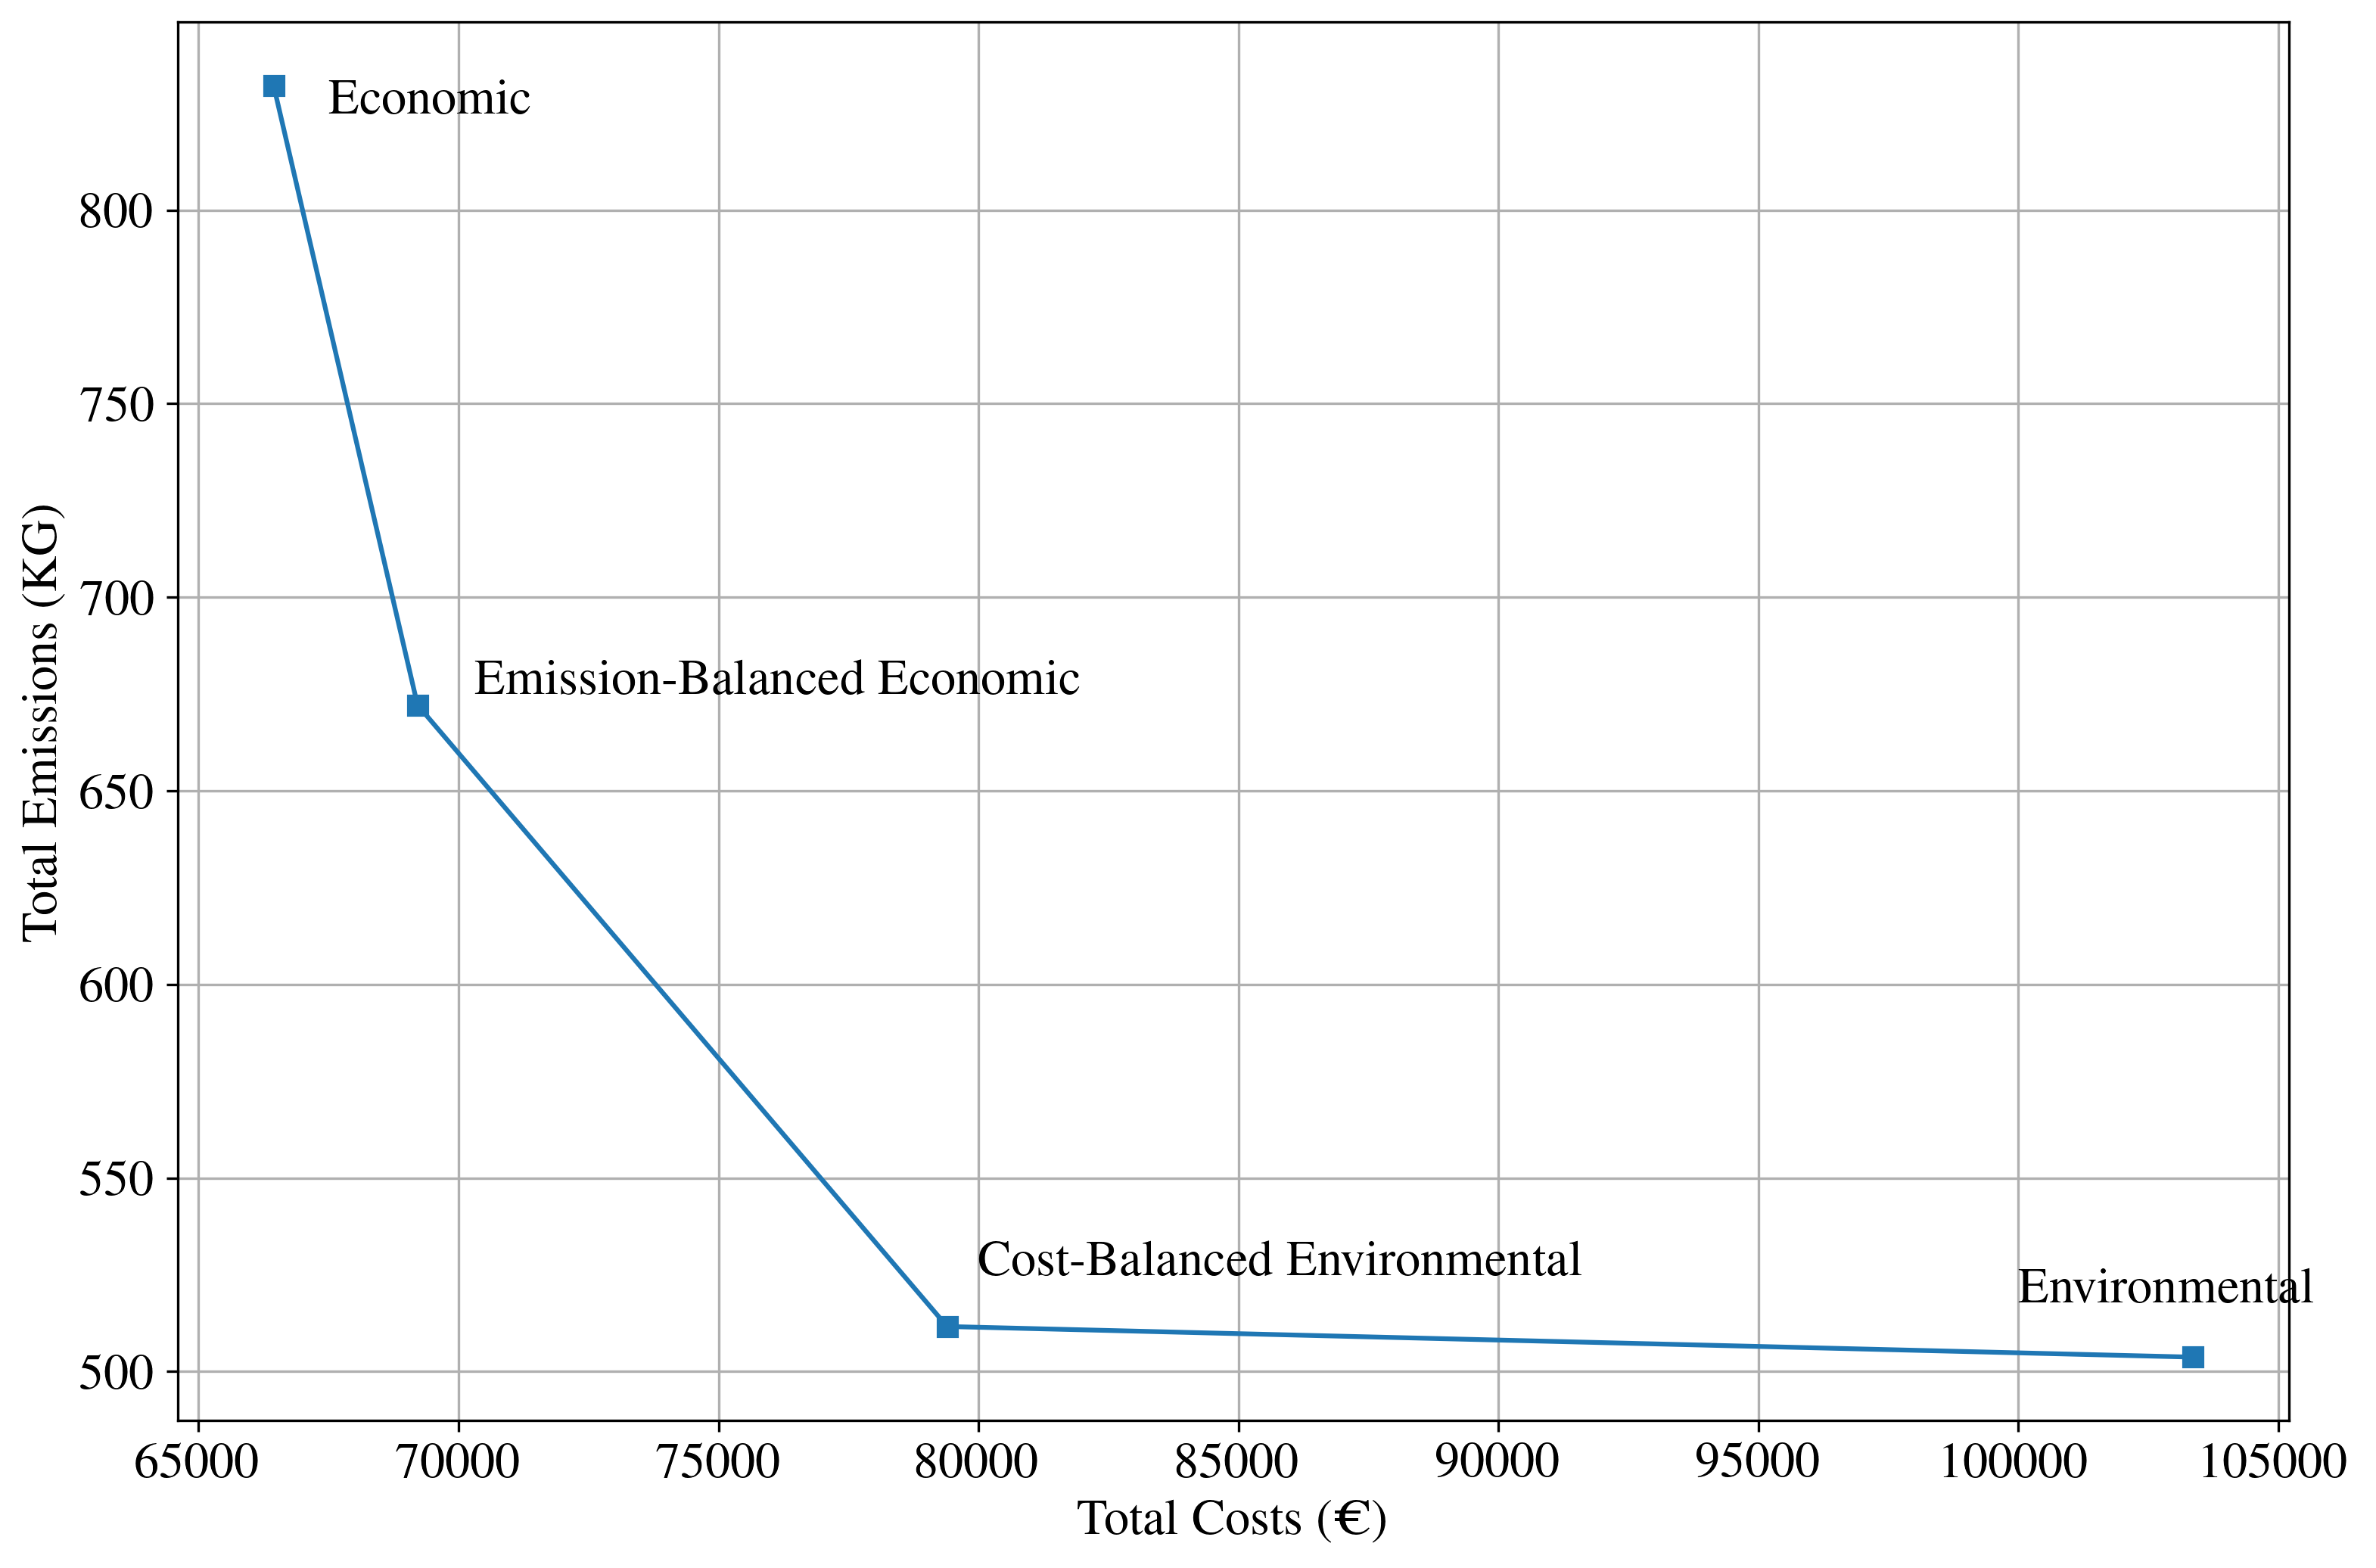

In [ ]:
# Plotting all the points for a pareto frontier
plt.figure(figsize = (12,8), dpi=300)

plt.plot(df['Cost_Obj'], df['Env_Obj'], marker='s', label='Total Cost vs Total Emissions')
plt.ylabel('Total Emissions (KG)')
plt.xlabel('Total Costs (€)')

plt.annotate('Economic', xy=(67500, 825), xytext=(67500, 825))
plt.annotate('Emission-Balanced Economic', xy=(70300, 675), xytext=(70300, 675))
plt.annotate('Cost-Balanced Environmental', xy=(80000, 525), xytext=(80000, 525))
plt.annotate('Environmental', xy=(100000, 518), xytext=(100000, 518))

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 16
plt.grid(True)

plt.savefig("models.png", bbox_inches = 'tight')

plt.show()
